<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/cv/cv-uis-student/raw/master/imgs/logo_CV.jpeg" style="width:1500px;heigth:100px">


# <center> 08. Computing keypoint as image features:ORB descriptor </center>


There are a bunch of different feature detectors and these all have some characteristics in common: they should be quick to find, and things that are close in image-space are close in feature-space (that is, the feature representation of an object looks like the feature representation of objects that look like that object).


## <span style="color:red"> Outline </span> 
1. **Describing images by Features**
2. **ORB descriptor: Oriented FAST and Rotated BRIEF**
3. **Matching images by features**

## <span style="color:green"> If you are in colaboratoy </span>: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive/cv-uis-student/notebooks
!pwd

## <span style="color:red"> 1. Describing images by Features </span> 

What are the most distinctive image regions ?

There are a lot of  feature detectors that try to find representative image regions that robustly describe objects. So, if object suffer transformations (namely afine) the feature regions remains the same. 

# Feature space

- Repeatability (got to be able to find it again)
- Distinctiveness/informativeness (features representing different things need to be different)
- Locality (they need to be local to the image feature and not, like, the whole image)
- Quantity (you need to be able to find enough of them for them to be properly useful)
- Accuracy (they need to accurately locate the image feature)
- Efficiency (they've got to be computable in reasonable time)

## Keypoints and associated Descriptor

1. Keypoints: spatial (x,y) locations that is the most representative points into scene. Namely corners, points with high gradient responses. 

<img src="../imgs/kd1.png" style="width:300px;">


2. Associated descriptors: Each of the keypoints could be described, nammelly by the regional information around each point.

<img src="../imgs/kd3.png" style="width:300px;">


## From such representations it is possible to achive invariance!

<img src="../imgs/kd2.png" style="width:300px;">

go to the action ...

In [1]:
import cv2 as cv
from skimage import transform as tf
from skimage import io
from skimage.color import rgb2gray
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import (match_descriptors, corner_harris,
                             corner_peaks, ORB, plot_matches)
from skimage import transform as tf

## <span style="color:red"> 2. ORB descriptor: Oriented FAST and Rotated BRIEF </span> 

It is a fast robust local feature detector [1]: 
- It is based on the FAST keypoint detector
- visual descriptor BRIEF (Binary Robust Independent Elementary Features).

#### Keypoint detector: FAST Keypoint Orientation

1. It is computed a Pyramid of the image
2. it is taken the intensity threshold between the center pixel and those in a circular ring about the center. (circular radius of 9)
3. This measure capture large responses along edges: **Gradients!**
4. It is fixed a threshold low enough to get more than N keypoints
5. A **Harris measure** it is defined to pick a subset of N points

<img src="../imgs/harris.png" style="width:700px;">
6. Compute the **Orientation by Intensity Centroid** by using definition of moments: 
    $$m_{pq} = \sum_x,y x^{p}y^{q}I(x,y)$$
    Then, the centroid is defined as:
    $$C(\frac{m_{10}}{m_{00}}, \frac{m_{01}}{m_{00}} )$$
    So, there is a vector betwwen the center of the corner and the centroid of the intensity. The orientation is computed as: 
    $$\theta = atan2(m_{01}, m_{10})$$
    
Now, see how **FAST Keypoint Orientation**  are computed in python   

In [2]:

img_test1 =io.imread('../data/image_set/cougar_body/image_0014.jpg')
descriptor_extractor = ORB(n_keypoints=200)
print img_test1.shape


descriptor_extractor.detect_and_extract(rgb2gray(img_test1))
keypoints1 = descriptor_extractor.keypoints

print keypoints1.shape


(216, 300, 3)
(200, 2)


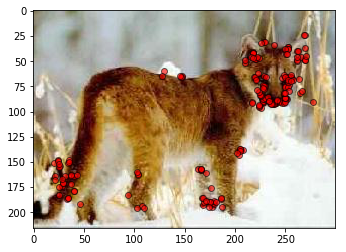

In [3]:
plt.imshow(img_test1); 
plt.scatter(keypoints1[:,1], keypoints1[:,0],c= "red",edgecolors="black", alpha=.6);
plt.imshow(img_test1); 

#### Visual Descriptor: BRIEF

Each patch $\mathbf{p}$ around the keypoint is described by a **bit string** built from a set of binary intensity tests. 

$$ \tau(\mathbf{p}, x,y) := \left\{\begin{matrix}
1 & \mathbf{p(x)}< \mathbf{p(y)}\\ 
0 & \mathbf{p(x)}\geq \mathbf{p(y)}
\end{matrix}\right.$$

with $\mathbf{p(x)}$ the intensity at point $x$. The feature vector is then defined by a vector of $n$ binary tests. 

$$f_{n}(\mathbf{p}):= \sum_{1 \leq i \leq n} 2^{i-1}\tau (\mathbf{p}, x,y)$$

No, we can see the descriptor of each of the points

(200, 256)


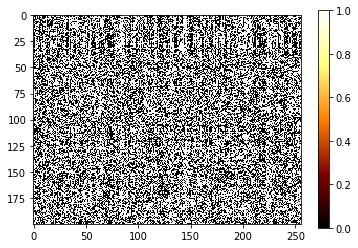

In [4]:
descriptors1 = descriptor_extractor.descriptors
print descriptors1.shape



fig, ax = plt.subplots()
cax = ax.imshow(descriptors1, interpolation='nearest',  cmap=plt.cm.afmhot)
cbar = fig.colorbar(cax)
plt.show()


## <span style="color:red"> 3. Matching images by features </span> 


Now, we go to transform the image...by using some affine transformations...

In [5]:
img_test2 = tf.rotate(img_test1 , 40)
tform = tf.AffineTransform(scale=(1.3, 1.1), rotation=0.5,
                           translation=(0, -200))
img_test3 = tf.warp(img_test1, tform)

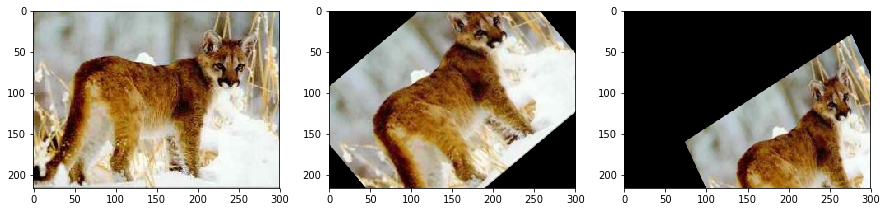

In [6]:
plt.figure(figsize=(15,4))
plt.subplot(131);
plt.imshow(img_test1); 
plt.subplot(132);
plt.imshow(img_test2, cmap='gray'); 
plt.subplot(133);
plt.imshow(img_test3, cmap='gray'); 

Compute the descriptors

In [7]:
descriptor_extractor.detect_and_extract(rgb2gray(img_test2))
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(rgb2gray(img_test3))
keypoints3 = descriptor_extractor.keypoints
descriptors3 = descriptor_extractor.descriptors

Now, we can match the keypoints by using the descriptor information

In [8]:
matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)
matches13 = match_descriptors(descriptors1, descriptors3, cross_check=True)

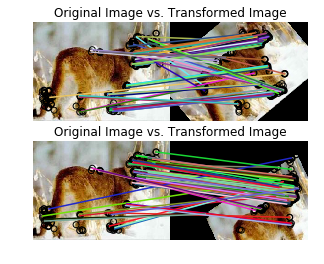

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=1)
plot_matches(ax[0], img_test1, img_test2, keypoints1, keypoints2, matches12)
ax[0].axis('off')
ax[0].set_title("Original Image vs. Transformed Image")

plot_matches(ax[1], img_test1, img_test3, keypoints1, keypoints3, matches13)
ax[1].axis('off')
ax[1].set_title("Original Image vs. Transformed Image")


plt.show()

## <span style="color:orange"> 3. student Challenge</span>: 

- Go to datasets and charge two images of `car_side` folder and two images of `char` folder
- Compute BRIEF descriptor for whole imges
- Visualize each of them. 
- Try to match them using ORB features. Something to stand out?


<type 'numpy.ndarray'> (71, 2)




# References

[1] BRIEF ORB: Rublee, Ethan; Rabaud, Vincent; Konolige, Kurt; Bradski, Gary (2011). "ORB: an efficient alternative to SIFT or SURF" (PDF). IEEE International Conference on Computer Vision (ICCV).


[2] Features in 2D:  https://docs.opencv.org/3.1.0/db/d27/tutorial_py_table_of_contents_feature2d.html

[3] Harris features: https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html

[4] M. Calonder, V. Lepetit, C. Strecha, and P. Fua. Brief: Binary robust independent elementary features. In In European Conference on Computer Vision, 2010 [pdf](https://www.cs.ubc.ca/~lowe/525/papers/calonder_eccv10.pdf)


<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/cv/cv-uis-student/raw/master/imgs/bannerThanks.jpg" style="width:1000px;">